# Courts and Rinks by Neighborhood
### Ben Osband

**First, let's import all the packages we'll need and set the theme for plotting.**

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame

%matplotlib inline

plt.style.use('ggplot')

**Then, let's read in the data about courts and rinks and the shapefile for Pittsburgh neighborhoods.**

In [2]:
data = pd.read_csv("https://data.wprdc.org/datastore/dump/a5b71bfa-840c-4c86-8f43-07a9ae854227")
neighborhoods = gpd.read_file('Neighborhoods/Neighborhoods_.shp')

**Now that we have all our data, let's take a look at it and see how we can determine which neighborhood is the best for recreation based on its courts and rinks**

In [3]:
data.head()

,_id,id,name,type,park,location,surface_material,grandstand,inactive,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1,1592343416,Allegheny Commons Basketball Court 1,Basketball (Full),Allegheny Commons,NaN,NaN,0,f,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.454443,-80.008104
1,2,1365248699,Allegheny Commons Park Tennis Court 1,Tennis,Allegheny Commons,NaN,Asphalt,0,f,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.452400,-80.012531
2,3,1757180821,Allegheny Commons Park Tennis Court 2,Tennis,Allegheny Commons,NaN,Asphalt,0,f,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.452238,-80.012150
3,4,744303307,Allegheny Commons Park Tennis Court 3,Tennis,Allegheny Commons,NaN,Asphalt,0,f,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.452075,-80.011767
4,5,1157777481,Alton Park Basketball Court 1,Basketball (Half),Alton Park,NaN,Asphalt,0,f,Beechview,4,19,42003191600,5,19,6,4-28,40.414152,-80.022305


**We can see that each row contains data about a particular park, including the neighborhood it belongs to, so first let's simply determine which neighborhood has the greatest number of courts and rinks.**

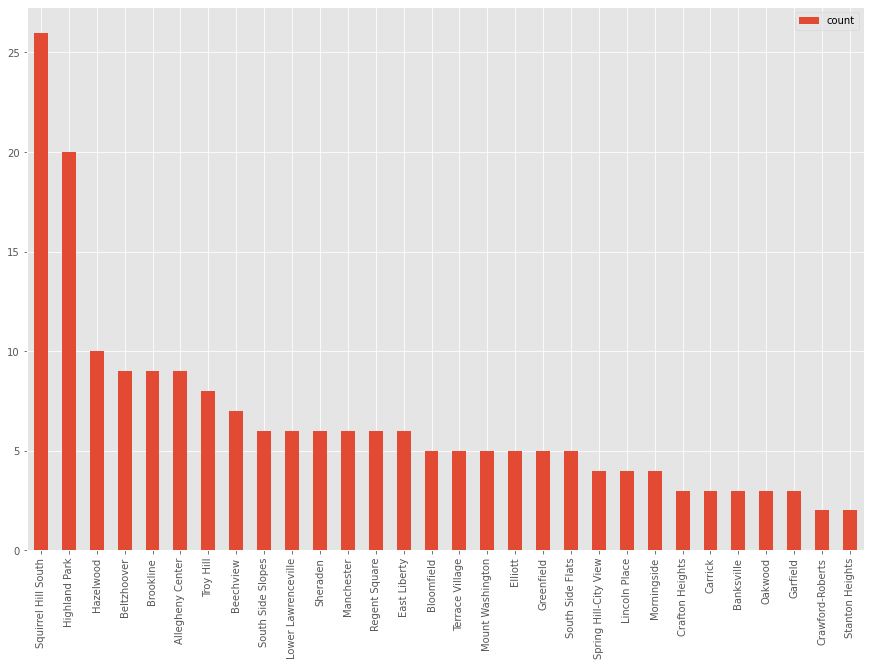

In [4]:
# Gets number of courts and rinks per neighborhood, converts it to a dataframe, and renames the neighborhood column to count
count_by_hood = data['neighborhood'].value_counts().to_frame()
count_by_hood.rename(columns={'neighborhood':'count'}, inplace=True)

count_by_hood.iloc[:30].plot(kind='bar', figsize=(15, 10))

**From plotting the top 30 neighborhoods, we can see that Squirrel Hill South, Highland Park, and Hazelwood have the top 3 greatest number of courts and rinks in Pittsburgh. This can also be seen visually below.**

<Figure size 432x288 with 0 Axes>

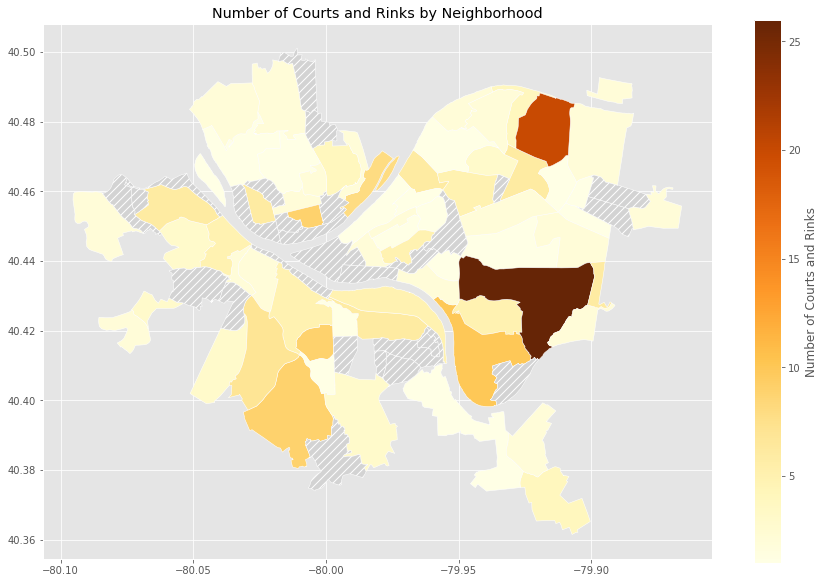

In [33]:
# Merges the counts per neighborhood 
quantity_map = neighborhoods.merge(count_by_hood, how='left', left_on='hood', right_on=count_by_hood.index)

plt.figure(1)

quantity_map.plot(
             column='count',
             cmap='YlOrBr',
             edgecolor='white',
             legend=True,
             figsize=(15, 10),
             legend_kwds={'label': 'Number of Courts and Rinks'},
             missing_kwds={'color': 'lightgrey', 'hatch': '///'})

plt.title('Number of Courts and Rinks by Neighborhood')
plt.show()

**Great, we know what neighborhoods have the most courts and rinks! However, there are a couple additional factors to consider.**

**First, some neighborhoods are significantly larger than others, which likely impacts the number of courts and rinks in any given neighborhood. For example, Highland Park only has 6 less courts and rinks than Squirrel Hill South, but from the map above we can see that Highland Park is considerably smaller in terms of area.**

**The actual locations of the courts and rinks are plotted below to given you an idea of the true distribution.**

<Figure size 432x288 with 0 Axes>

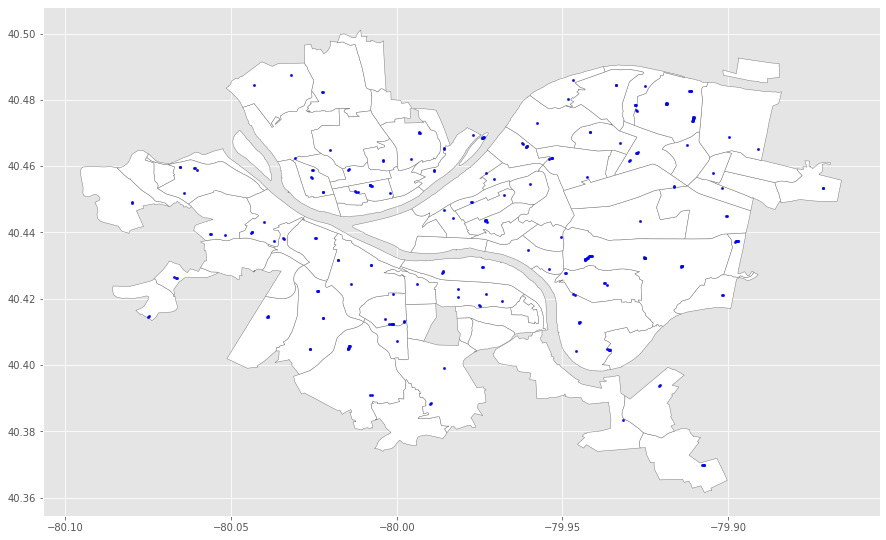

In [26]:
# Creates a point for each latitude and longitude and then creates a GeoDataFrame
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf = GeoDataFrame(data, geometry=geometry)

# Changes to plot 2
plt.figure(2)

# Plots the base map and then plots the dots on top of it
base = gpd.read_file('Neighborhoods/Neighborhoods_.shp')
gdf.plot(
    ax=base.plot(figsize=(15, 10),
    color='white',
    edgecolor='grey'),
    figsize=(15, 10),
    marker='o',
    color='blue',
    markersize=5)

# Ensures the plot is shown here and not above
plt.show()


**As you can see, the courts and rinks are not necessarily concentrated in the neighborhoods with the most of them. To account for this, we will consider the _density_ of courts and rinks in each neighborhood.**

Text(0.5, 0, 'Neighborhood')

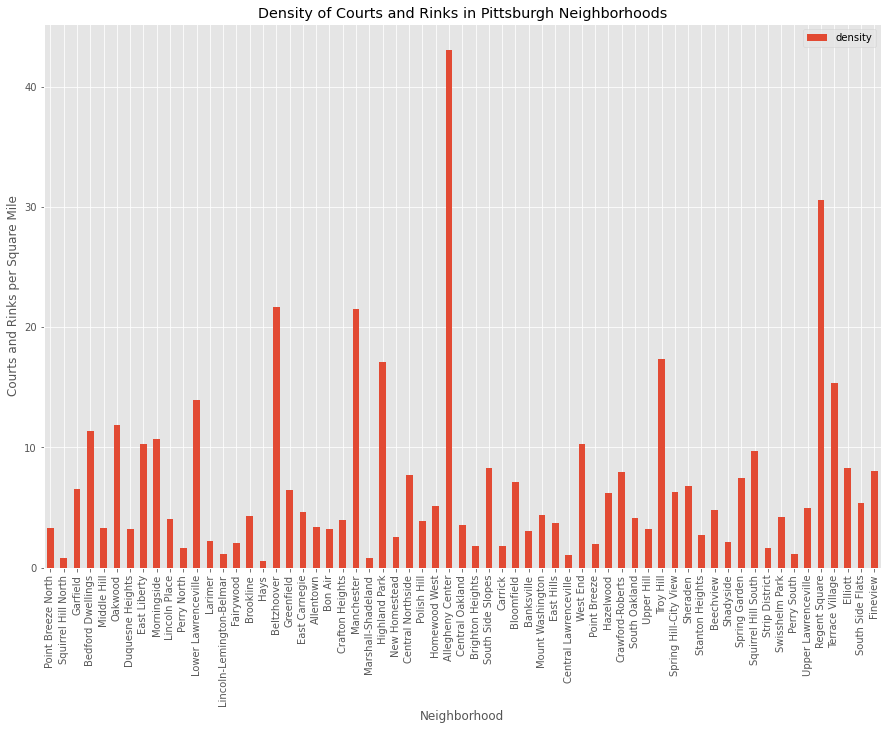

In [27]:
# Combines the neighborhoods and their respective square mileage into a dataframe
density_data = pd.concat([neighborhoods['hood'], neighborhoods['sqmiles']], axis=1)

# Sets the index to be the neighborhood
density_data.set_index('hood', inplace=True)

# Merges the number of courts and rinks by neighborhood to the square mileage by neighborhood
density_data = density_data.merge(count_by_hood, how='left', left_on=density_data.index, right_on=count_by_hood.index)

# Renames the key_0 column to neighborhood and then sets that to be the index again
density_data.rename(columns={'key_0': 'neighborhood'}, inplace=True)
density_data.set_index('neighborhood', inplace=True)

# Removes null values to account for neighborhoods with no courts or rinks
density_data = density_data[density_data[['sqmiles', 'count']].notnull().all(1)]

# Creates a list to store density values in
densities = []

# Iterates through each row in the data
for index, row in density_data.iterrows():
    
    # Divides the number of courts and rinks in each neighborhood by the square mileage
    # of that neighborhood to get the number of courts and rinks per square mile
    count = row[1]
    area = row[0]
    density = count / area
    densities.append(density)

# Creates a new column for densities
density_data['density'] = densities

# Creates bar chart and adds labels
density_data.plot(kind='bar', y='density', figsize=(15, 10))
plt.title('Density of Courts and Rinks in Pittsburgh Neighborhoods')
plt.ylabel('Courts and Rinks per Square Mile')
plt.xlabel('Neighborhood')


**This bar chart is the density of courts and rinks in each neighborhood by courts and rinks per square mile. In it's current form, though, it's cluttered and not very helpful, so let's sort it and filter it down to neighborhood's with a density of more than 7 courts and rinks per square mile.**

Text(0.5, 0, 'Neighborhood')

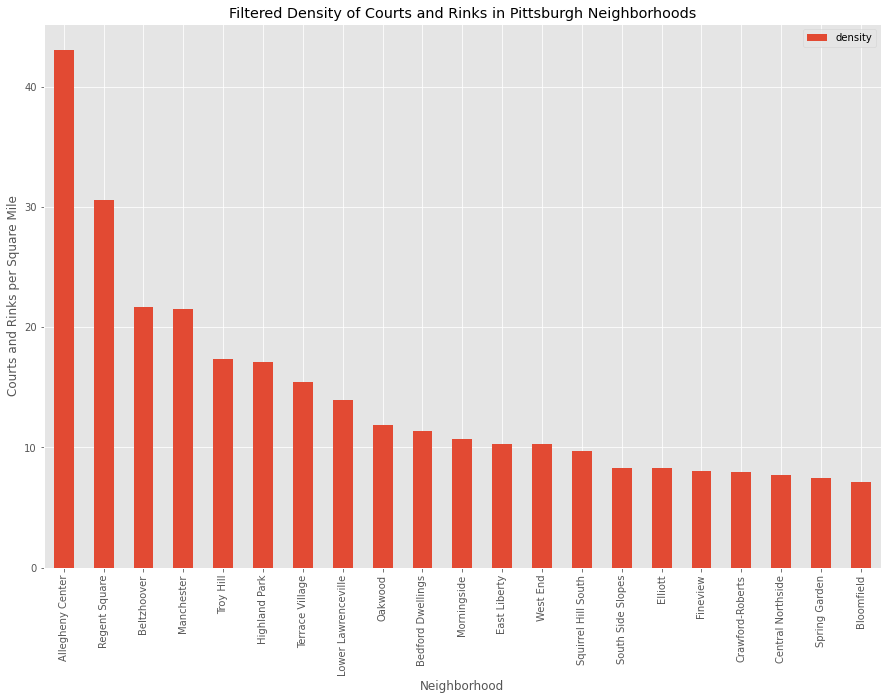

In [28]:
# Creates filter mask
density_mask = density_data['density'] >= 7

# Filters the data into a new dataframe using the mask
filtered_density_data = density_data[density_mask]

filtered_density_data = filtered_density_data.sort_values('density', ascending=False)

# Plots the newly filtered data and adds labels
filtered_density_data.plot(kind='bar', y='density', figsize=(15, 10))
plt.title('Filtered Density of Courts and Rinks in Pittsburgh Neighborhoods')
plt.ylabel('Courts and Rinks per Square Mile')
plt.xlabel('Neighborhood')


**As you can see, the neighborhoods with the greatest densities of courts and rinks are Allegheny Center, Regent Square, Beltzhoover, and Manchester. These results differ greatly from the initial approach of the neighborhood with the greatest number of courts and rinks, and provides a more accurate depiction of the accessibility of these courts and rinks.**

**Let's look at this visually.**

<Figure size 432x288 with 0 Axes>

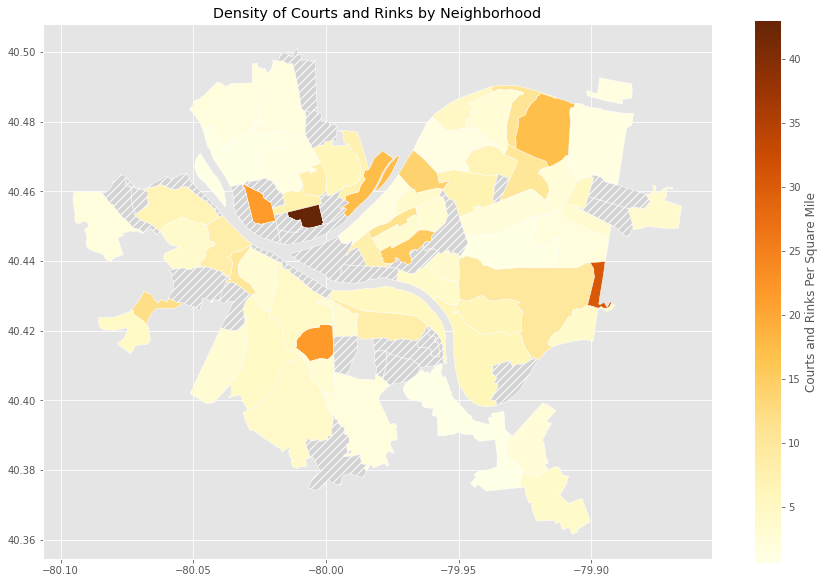

In [34]:
# Merges density data with map data
density_map = neighborhoods.merge(density_data, how='left', left_on='hood', right_on=density_data.index)

plt.figure(3)

# Plots the map
density_map.plot(
             column='density',
             cmap='YlOrBr',
             edgecolor='white',
             legend=True,
             figsize=(15, 10),
             legend_kwds={'label': 'Courts and Rinks Per Square Mile'},
             missing_kwds={'color': 'lightgrey', 'hatch': '///'})

plt.title('Density of Courts and Rinks by Neighborhood')

plt.show()

**Highland Park and Beltzhoover both appear high in the rankings of both quantity and density, and Squirrel Hill South has the greatest number of courts and rinks, so as of now we will consider Highland Park, Beltzhoover, and Squirrel Hill South the contenders for best neighborhood.**

**There is something to be said about considering a a middle ground between density and quantity of courts and rinks, and this brings us to the other important factor. That is, if a neighborhood is very small but has a few courts and rinks, it's density will be relatively high, but we have to keep in mind that there are different types of courts and rinks.**

**Below you can see the various types of courts**

In [10]:
types = data['type'].unique().tolist()
print(types)

['Basketball (Full)', 'Tennis', 'Basketball (Half)', 'General Sports', 'Street Hockey', 'Dek Hockey', 'Hockey', 'Pickleball', 'Volleyball', 'Lawn Bowling', 'Bocce', 'Horseshoe Pit']


**Thus, we will consider the _variety_ of courts and rinks in each neighborhood.**

**Below is a bar chart of the number of types of courts and rinks in each neighborhood with neighborhoods with only 1 type filtered out.**

Text(0.5, 0, 'Neighborhood')

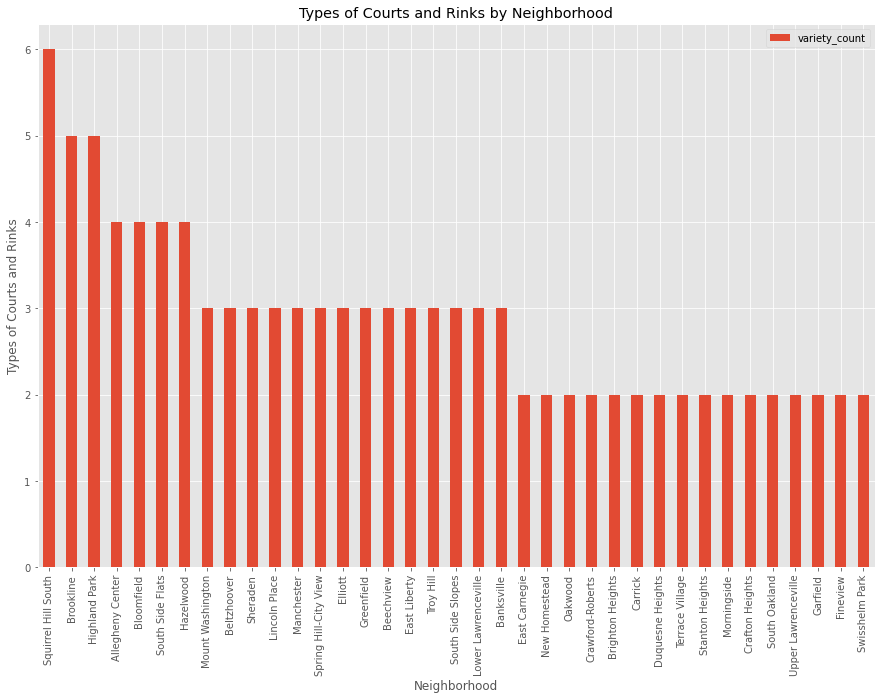

In [11]:
# Creates a dictinoary to store a list of the types of courts and rinks in each neighborhood
variety_dict = {}

# Iterates through each court and rink from the original dataset
for index, row in data.iterrows():
    
    # Gets the neighborhood and type of facility
    nhood = row[9]
    rec_type = row[3]
    
    # if the neighborhood doesn't have any entries yet, creates a new list
    if nhood not in variety_dict:
        variety_dict[nhood] = [[rec_type]]
    # otherwise, if the type of facility is not already in the list, adds it to the list
    elif rec_type not in variety_dict[nhood][0]:
        variety_dict[nhood][0].append(rec_type)


# Transforms into usable dataframe
variety_data = pd.DataFrame.from_dict(variety_dict)
variety_data = variety_data.transpose()
variety_data.rename(columns={0: 'types'}, inplace=True)

# List to store counts
counts = []

# Iterates through each neighborhood in the new dataframe
for index, row in variety_data.iterrows():
    
    # adds the number of types of facilities to the counts list
    counts.append(len(row[0]))

# Adds column for the number of types of facilities for each neighborhood
variety_data['variety_count'] = counts

filtered_variety_data = variety_data[variety_data['variety_count'] > 1]
filtered_variety_data = filtered_variety_data.sort_values('variety_count', ascending=False)

# Plots data
filtered_variety_data.plot(kind='bar', y='variety_count', figsize=(15, 10))
plt.title('Types of Courts and Rinks by Neighborhood')
plt.ylabel('Types of Courts and Rinks')
plt.xlabel('Neighborhood')

**As you can see, Squirrel Hill South, Brookline, and Highland Park have the top 3 greatest varieties of courts and rinks.**

**Let's look at a map of this data.**

<Figure size 432x288 with 0 Axes>

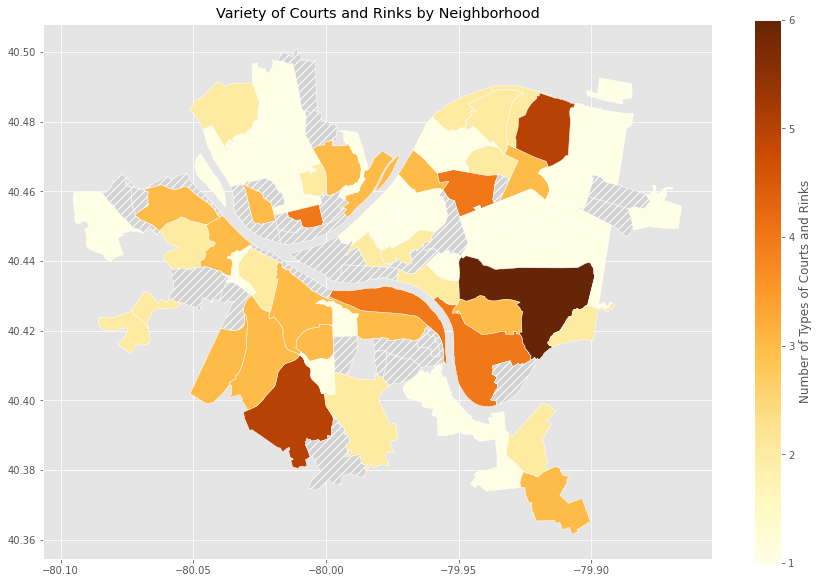

In [35]:
variety_map = neighborhoods.merge(variety_data, how='left', left_on='hood', right_on=variety_data.index)


plt.figure(4)

variety_map.plot(
             column='variety_count',
             cmap='YlOrBr',
             edgecolor='white',
             legend=True,
             figsize=(15, 10),
             legend_kwds={'label': 'Number of Types of Courts and Rinks'},
             missing_kwds={'color': 'lightgrey', 'hatch': '///'})

plt.title('Variety of Courts and Rinks by Neighborhood')

plt.show()

**Looking at how neighborhoods appear across different measures, we can see that Beltzhoover and Allegheny Center have good density but not enough variety, which leaves us with Squirrel Hill South and Highland Park as our contenders for best neighborhood. Squirrel Hill South has the greatest number of courts and rinks and has the most variety, but Highland Park is a close runner-up in both of those categories and has greater density than Squirrel Hill South. This lack of density in Squirrel Hill South may make it more inconvenient to get from one facility to another, especially for someone without a personal vehicle.**